Бежим по входному изображению сверткой 5x5 с шагом 5. Классифицируем каждый кусочек как сторону доски кроссэнтропией.

In [1]:
cd ..

/home/bfilippov/kaggle/whiteboard


In [2]:
import keras
import pandas as pd
import ast
import numpy as np 
import cv2 


train = pd.read_csv('source/train.csv')
test = pd.read_csv('source/test.csv')
train['labels'] = train['labels'].map(ast.literal_eval)
test['labels'] = test['labels'].map(ast.literal_eval)

valid = train.sample(frac=0.2, random_state=1313)
train = train.drop(valid.index)

Using TensorFlow backend.


In [3]:
def cv_feature_maps(image):
    alpha = image[:, :, 3].copy() # special mask used to ignore image-augmentation artifacts
    gray = (cv2.cvtColor(image[:, :, :3].astype(np.float32), cv2.COLOR_RGB2GRAY) * 255).astype(np.uint8)
    edges = cv2.Canny(gray, 100, 250)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 25, minLineLength=50, maxLineGap=50)

    corners = cv2.cornerHarris(edges,2,3,0.01)
    corners = cv2.dilate(corners,None)
    
    hough = np.zeros(gray.shape, np.float)

    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(hough, (x1, y1), (x2, y2), 1, 2)
    
    def norm(img):
        return cv2.normalize(img, img, 0, 1, norm_type=cv2.NORM_MINMAX, 
                             dtype=cv2.CV_32F)
    feature_maps = [norm(img) for img in [gray, edges, corners, hough, alpha]]
    return np.stack(feature_maps, axis=2)
    

In [4]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf

from keras import backend as K

sess = tf.Session()
K.set_session(sess)

input_height = 200
input_width = 150


In [5]:
def psin(x):
    alpha = tf.constant(1.0)
    beta = tf.constant(1.0)
    return beta * tf.sin(alpha * x)

def pcos(x):
    alpha = tf.constant(1.0)
    beta = tf.constant(1.0)
    return beta * tf.cos(alpha * x)

In [6]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Convolution2D, Dense, Dropout, Flatten, Lambda

import tensorflow as tf

nb_filters = 32
patch_size = 5
agg_size = 6
second_agg_size = 2
dropout_pb = 0.5
nb_cv_features = 5
out_size = (input_width // patch_size, input_height // patch_size)

model = Sequential()
model.add(BatchNormalization(input_shape=(input_height, input_width, nb_cv_features), name='input_norm'))
model.add(Convolution2D(nb_filters, patch_size, patch_size, subsample=(patch_size, patch_size), 
                        name='patch_conv', activation=psin))
model.add(Dropout(dropout_pb))
model.add(BatchNormalization(name='hidden_norm'))
model.add(Convolution2D(nb_filters, agg_size, agg_size, subsample=(1, 1), 
                        name='aggregated_conv', border_mode='same', activation=pcos))
model.add(Dropout(dropout_pb))
model.add(BatchNormalization(name='patch_norm'))
# compute probability of corner for each patch using aggregated feature maps.
model.add(Convolution2D(1, 1, 1, subsample=(1, 1), activation='sigmoid', name='sigmoid_conv'))
# well it can cheat by assigning very low probs. Let's just keep it off for now
#model.add(Lambda(lambda x: x / tf.reduce_max(x), name='norm_probs'))

#model.load_weights('models/weights/corner_detector_relu.hf5', by_name=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [7]:
class PatchLabelIterator:
    line_thickness = 2
    def __init__(self, whiteboard_images, out_size):
        self.whiteboard_images = whiteboard_images
        self.out_size = out_size[::-1]
        
    def __point(self, batch, k):
        x_val = int(batch[k] // patch_size)
        y_val = int(batch[k + 4] // patch_size)            
        return x_val, y_val
    
    def __next__(self):
        batch_x, batch_y = next(self.whiteboard_images)
        patch_x = np.zeros(batch_x.shape[:-1] + (nb_cv_features,))
        patch_y = np.zeros((batch_y.shape[0],) + self.out_size + (1,))
        for i, batch in enumerate(batch_y):
            patch_x[i] = cv_feature_maps(batch_x[i])
            if batch[0]:
                for a, b in [(2, 3), (3, 4), (4, 5), (5, 2)]:
                    cv2.line(patch_y[i], self.__point(batch_y[i], a), 
                             self.__point(batch_y[i], b), 1, self.line_thickness)
        return patch_x, patch_y

In [8]:
from models.image_generator import whiteboard_images

img_size = (input_height, input_width)
img_dir = 'source'
batch_size = 32

def patch(gen):
    return PatchLabelIterator(gen, out_size)

train_imgs = patch(whiteboard_images(train, img_dir, img_size, batch_size=batch_size)) 
valid_imgs = patch(whiteboard_images(valid, img_dir, img_size, batch_size=batch_size, seed=1313))
test_imgs = patch(whiteboard_images(test, img_dir, img_size, batch_size=batch_size))

In [9]:
model.fit_generator(train_imgs, samples_per_epoch=1024, nb_epoch=50, validation_data=valid_imgs, 
                    nb_val_samples=32)

Epoch 1/50
1024/1024 [==============================] - 198s - loss: 0.7370 - val_loss: 0.5292
Epoch 2/50
1024/1024 [==============================] - 240s - loss: 0.6007 - val_loss: 0.4512
Epoch 3/50
1024/1024 [==============================] - 227s - loss: 0.5257 - val_loss: 0.4066
Epoch 4/50
1024/1024 [==============================] - 252s - loss: 0.4713 - val_loss: 0.3490
Epoch 5/50
1024/1024 [==============================] - 249s - loss: 0.4272 - val_loss: 0.3347
Epoch 6/50
1024/1024 [==============================] - 209s - loss: 0.4037 - val_loss: 0.3076
Epoch 7/50
1024/1024 [==============================] - 228s - loss: 0.3855 - val_loss: 0.3127
Epoch 8/50
1024/1024 [==============================] - 223s - loss: 0.3693 - val_loss: 0.2935
Epoch 9/50
1024/1024 [==============================] - 178s - loss: 0.3654 - val_loss: 0.2863
Epoch 10/50
1024/1024 [==============================] - 160s - loss: 0.3614 - val_loss: 0.2896
Epoch 11/50
1024/1024 [==========================

In [10]:
model.save_weights('corner_detector_relu.hf5')

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import patches

img_ix = 3

height_patches = input_height / patch_size
width_patches = input_width / patch_size
height_len = input_height / height_patches
width_len = input_width / width_patches

def draw_rect(x, y, p, color):
    return patches.Rectangle(
        (y * height_len, x * width_len),
        height_len,
        width_len,
        alpha=p,
        color = color
    )

def draw_rects(plt, matrix, color):
    
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.add_patch(draw_rect(i, j, matrix[i, j], color))

        

def draw_example(imgs, include_alpha=True):
    test_batch_x, test_batch_y = next(train_imgs)
    
    if not include_alpha:
        test_batch_x = test_batch_x.copy()
        for i in range(batch_size):
            test_batch_x[i, :, :, 4] = np.ones(test_batch_x.shape[1:3])
    
    plt.subplot(141)
    plt.imshow(test_batch_x[img_ix][:, :, 0], cmap='gray')
    draw_rects(plt.gca(), test_batch_y[img_ix], 'blue')

    prediction_y = model.predict_on_batch(test_batch_x)

    plt.subplot(142)
    plt.imshow(test_batch_x[img_ix][:, :, 0], cmap='gray')
    draw_rects(plt.gca(), prediction_y[img_ix] 
               #/ prediction_y[img_ix].max()
               , 'red')


    plt.subplot(143)
    plt.imshow(test_batch_x[img_ix, :, :, 4], cmap='gray')
    #plt.plot(test_batch_y[img_ix][6:10], test_batch_y[img_ix][2:6], '+')
    #plt.plot(predictions[img_ix][2:6], predictions[img_ix][6:10], 'o')

    plt.subplot(144)
    plt.imshow(cv2.dilate(prediction_y[img_ix], None), cmap='gray')

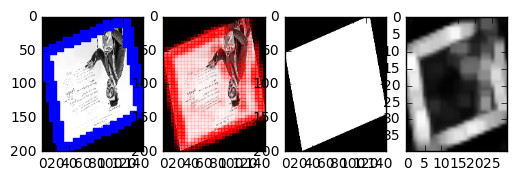

In [22]:
draw_example(valid_imgs)

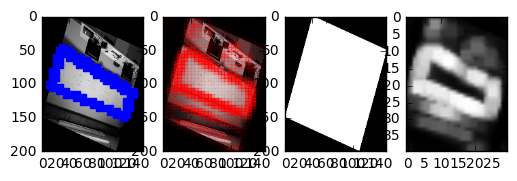

In [21]:
draw_example(test_imgs)